Homework 1
Name: Long Nguyen


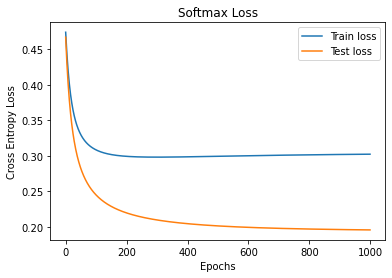

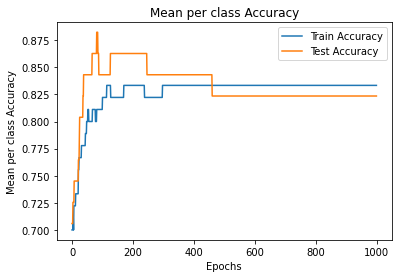

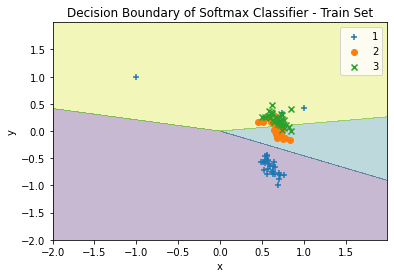

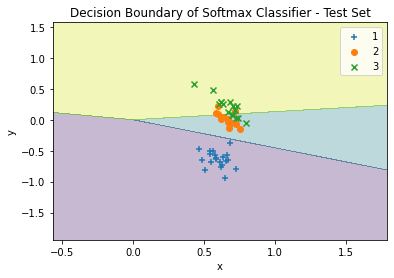

In [2]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %% [markdown]
# Homework 1
# Name: Long Nguyen
# 

# %%
import numpy as np
import random
import matplotlib.pyplot as plt
import time

class SoftmaxClassifier:
    
    def __init__ (self, epoch, learnRate, batchSize, regStrength, momentum):
        self.epoch = epoch
        self.learnRate = learnRate
        self.batchSize = batchSize
        self.regStrength =regStrength
        self.weight = None
        self.momentum = momentum 

    
    def train (self, x, y, xTest, yTest):
        """"
           x: data, y: label
           repeat every epoch
           return loss and acc
        """

        data_dimension = x.shape[1]
        label = np.unique(y)
        numLabel = len(label)
        y_enc = self.oneHotEncoding(y,numLabel)
        yEncTest = self.oneHotEncoding(yTest,numLabel)
        
        self.weight = 0.001*np.random.rand(data_dimension, numLabel)
        self.velocity = np.zeros (self.weight.shape)
        Loss_record = []
        Acc_record =[]

        Loss_record_test = []
        Acc_record_test =[]


        for _ in range(self.epoch): #loop over epochs (all data set)
            # for training, update weight each time
            
            trainLoss = self.train_minibatch(x,y_enc)
            accuracy = self.meanPerClass(x,y)
            Acc_record.append(accuracy)
            Loss_record.append(trainLoss)


            ### this is for testing, weight is not updated

            testLoss, notuse = self.computeLoss(xTest, yEncTest)
            accuracy = self.meanPerClass(xTest,yTest)
            Acc_record_test.append(accuracy)
            Loss_record_test.append(testLoss)


        return Loss_record, Acc_record, Loss_record_test, Acc_record_test

    def test (self, x, y):
        """"
           x: data, y: label
           return testLoss, testAccuracy
        """

    def oneHotEncoding(self, y,numLabel): 
        """
            encode class as 1 : 010, 2 : 001
        """
        y_unique = np.unique(y)
        identity = np.eye(numLabel)
        yEnc = np.zeros([y.shape[0], numLabel])
        for i in range(y.shape[0]):
            idx = np.where(y_unique == y[i])
            yEnc[i] = identity[idx]
        return yEnc  
        
    def train_minibatch(self,x,y):
        """
            compute gradient of mini batches
            Update weight repeatedly each batch
        """
        losses = []
        
        for i in range(0,len(x), self.batchSize):
            xBatch = x[i:i+self.batchSize]
            yBatch = y[i:i+self.batchSize]
            loss, grad = self.computeLoss(xBatch,yBatch)
            self.velocity = self.momentum*self.velocity + self.learnRate*grad
            self.weight = self.weight + self.velocity
            losses.append(loss)
        return np.mean(losses)
        
    def softmax(self,input):
        e_x = np.exp(input - np.max(input))
        e_x_sum = np.sum(e_x, axis = 1)
        output  = e_x/e_x_sum[:,None]
        return output

    def computeLoss(self,x,yEnc):
        """
            compute loss and gradent for mini_batch 
        """
        numOfSample = len(x)
        y_predict = np.dot(x, self.weight) # output  for specific class 
        prob = self.softmax(y_predict) # probability of each prediction using softmax 
        loss = np.sum(-np.log10(prob)*yEnc )/numOfSample + 1/2 * self.regStrength * np.sum(self.weight*self.weight)
        gradient = 1/numOfSample *np.dot(x.T,(yEnc-prob)) + (self.regStrength*self.weight)
        return loss, gradient

    def meanPerClass (self,xtopredict,groundtruth):
        """
            calculate mean per class: c
            compare actual y and predicted y
        """
        ypred = self.predict(xtopredict)

        return np.mean(np.equal(groundtruth,ypred))
    
    def predict(self,x):
        # only need x and finalized weight -> output predicted y
        ypred = x.dot(self.weight)
        return np.argmax(ypred,axis = 1)

    
def shuffle_data(x,y):
    idx = list(range(len(x)))
    random.shuffle(idx)
    x_new  = x[idx]
    y_new = y[idx]  
    return x_new, y_new

def scatter(data_train, label_train):
    markers = ('+','o','x')
    colors = ('red', 'green', 'blue')
    for idx, cl in enumerate(np.unique(label_train)):
            xBasedOnLabel = data_train[np.where(label_train == cl)]
            plt.scatter(x=xBasedOnLabel[:, 0], y=xBasedOnLabel[:, 1], cmap=colors,marker=markers[idx],label=cl+1)

def load_data(train_file,test_file):
    label_train = np.loadtxt(train_file,usecols=0,skiprows=0, dtype='int') - 1
    data_train = np.loadtxt(train_file,usecols=(1,2))
    label_test = np.loadtxt(test_file,usecols=0,skiprows=0, dtype='int') - 1
    data_test = np.loadtxt(test_file,usecols=(1,2))
    [data_train, label_train] = shuffle_data(data_train, label_train)
    [data_test, label_test] = shuffle_data(data_test,label_test)
    return label_train, data_train, label_test, data_test

def plotGraph(trainlossRecord, testLossRecord, trainAccuracy, testAccuracy):
    plt.plot(trainlossRecord, label="Train loss")
    plt.plot(testLossRecord, label="Test loss")
    plt.legend(loc='best')
    plt.title("Softmax Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")

    plt.figure()
    plt.plot(trainAccuracy, label="Train Accuracy")
    plt.plot(testAccuracy, label="Test Accuracy")
    plt.legend(loc='best')
    plt.title("Mean per class Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Mean per class Accuracy")
    plt.show()

def plotDecisionBoundary (model,x,y,type1):
    resolution = 0.001

    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xv, yv = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    ## create regions of classes, by create mesh can times with weights
    arr = np.array([xv.ravel(), yv.ravel()]) # create mesh, x and y 
    scores = np.dot(arr.T, model.weight)
    prob = model.softmax(scores)
    Z = np.argmax(prob, axis=1) + 1

    # Put result into a color plot
    Z = Z.reshape (xv.shape)
    plt.contourf (xv, yv, Z, alpha=0.3)
    scatter(x, y)


    plt.xlim (xv.min(), xv.max())
    plt.ylim(yv.min(), yv.max())
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Decision Boundary of Softmax Classifier - "+type1+ " Set")
    plt.legend(loc='upper right')
    plt.show()

if __name__ == '__main__':
    [label_train, data_train, label_test, data_test] = load_data("iris-train.txt","iris-test.txt")
    data_train = 2*(data_train - 0.5)
    data_test = 2*(data_test - 0.5)
    """
    lr 0.05, e 1000 bs 10 r 0.001 m 0.05
    """
    start = time.time()
    sm = SoftmaxClassifier(epoch=1000, learnRate=0.06, batchSize=10, regStrength=0.0005, momentum=0.07)
    [trainlossRecord, trainAccuracy,testLossRecord,testAccuracy] = sm.train(data_train,label_train,data_test,label_test)
    plotGraph(trainlossRecord,testLossRecord,trainAccuracy,testAccuracy)
    plotDecisionBoundary(sm,data_train,label_train,"Train")
    plotDecisionBoundary(sm,data_test,label_test,"Test")
    end = time.time()



In [4]:
import wandb
wandb.init(project="HW1")
wandb.log({'accuracy': train_acc, 'loss': train_loss})

AttributeError: module 'wandb' has no attribute 'init'

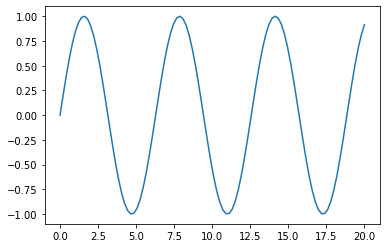

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 20, 100)  # Create a list of evenly-spaced numbers over the range
plt.plot(x, np.sin(x))       # Plot the sine of each x point
plt.show()                   # Display the plot